In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from keras.models import Model
from keras.layers import Conv2D, Input, ReLU,concatenate,Cropping2D, BatchNormalization, Flatten,Dense,Reshape,MaxPooling2D,UpSampling2D
from keras.layers import Conv2D, Conv2DTranspose, Input, ReLU,BatchNormalization,LeakyReLU,Identity
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam


from keras.datasets import mnist
import tensorflow as tf

import keras
from keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint


2024-08-02 15:37:38.013972: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [3]:
!wget  -nc https://www.dropbox.com/scl/fi/uaiyxp0t2l8hfcszfadtj/dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius&dl=1
!unzip -n -q dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius

/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/igu/miniconda3/envs/ml/lib/python3.9/site-packages/cv2/../../../../lib/libtinfo.so.6: no version information available (required by /bin/bash)
unzip:  cannot find or open dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius, dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.zip or dados.zip?rlkey=lnqcb79vbu8j6cdbfgofogius.ZIP.

No zipfiles found.


In [4]:
image_path = '../dados/CAPTCHA-10k/treinamento'
def generate_df(image_path):
  label_path = '../dados/CAPTCHA-10k/labels10k'

  jpg_files = [f for f in os.listdir(image_path) if f.endswith('.jpg')]
  jpg_files.sort()
  data = []

  for jpg_file in jpg_files:
      txt_file = os.path.splitext(jpg_file)[0] + '.txt'
      txt_file_path = os.path.join(label_path, txt_file)

      if os.path.exists(txt_file_path):
          with open(txt_file_path, 'r') as file:
              txt_content = file.read().strip()

          data.append({'jpg_file': jpg_file, 'txt_content': txt_content})
  return pd.DataFrame(data)

df = generate_df(image_path)
df.head()

,jpg_file,txt_content
0,000001.jpg,RNINIC
1,000002.jpg,TVCFS8
2,000003.jpg,N1O1EH
3,000004.jpg,OQZSL4
4,000005.jpg,GST2YA


In [5]:
df['txt_content'].str.len().value_counts()

txt_content
6    7997
7       3
Name: count, dtype: int64

In [6]:
from PIL import Image, ImageDraw, ImageFont

font_path = '../dados/targa/Targa.ttf'

In [7]:
def generate_clean_captcha(text):
    # Fixed parameters
    size = (180, 50)  # Change size to (height, width)
    font_size = 24
    num_parts = 7

    # Create a blank white image
    image = Image.new('L', size, 255)  # 'L' mode for grayscale

    # Load the custom font
    font = ImageFont.truetype(font_path, font_size)

    # Create a drawing context
    draw = ImageDraw.Draw(image)

    # Calculate positions for each part
    part_width = size[0] / num_parts
    horizontal_positions = [int(part_width * i + part_width / 2) for i in range(num_parts)]
    horizontal_positions = horizontal_positions[:len(text)]  # Adjust to the length of the text

    # Calculate y position to center the text vertically
    text_bbox = draw.textbbox((0, 0), text, font=font)
    text_height = text_bbox[3] - text_bbox[1]
    text_y = (size[1] - text_height) // 2

    # Draw each letter at the calculated position
    for char, x in zip(text, horizontal_positions):
        char_bbox = draw.textbbox((0, 0), char, font=font)
        char_width = char_bbox[2] - char_bbox[0]
        char_x = x - char_width // 2  # Center the character horizontally within its part
        draw.text((char_x, text_y), char, font=font, fill=0)

    # Convert to numpy array if needed for further processing with OpenCV
    captcha_image = np.array(image)

    return captcha_image

In [8]:
def preprocess(img):
  kernel  = cv2.getStructuringElement(cv2.MORPH_RECT, (4, 4))
  img     = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
  _, img  = cv2.threshold(img, 90, 255, cv2.THRESH_BINARY)
  return img

In [9]:
def generate_X_Y(image_path):
  df = generate_df(image_path)
  df['has_question_mark'] = df['txt_content'].str.contains(r'\?')
  df = df[df['has_question_mark'] == False]

  df['txt_content'] = df['txt_content'].apply(lambda x: x + "]" if len(x) == 6 else x)
  X = [preprocess(cv2.imread(os.path.join(image_path, x),cv2.IMREAD_GRAYSCALE)) for x in df["jpg_file"]]
  X = np.array(X)
  X = np.expand_dims(X, axis=-1)

  Y = np.array([generate_clean_captcha(x) for x in df["txt_content"]])
  X = X.astype('float32') / 255.
  Y = Y.astype('float32') / 255.
  return X,Y

X_train, Y_train = generate_X_Y('../dados/CAPTCHA-10k/treinamento')
X_val, Y_val = generate_X_Y('../dados/CAPTCHA-10k/validacao')

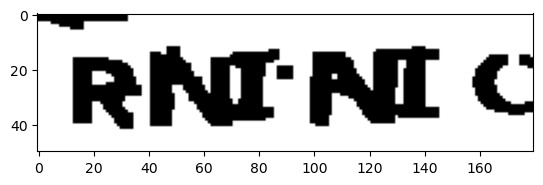

In [10]:
plt.imshow(X_train[0], cmap='gray')

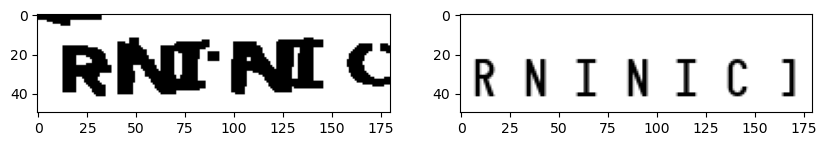

In [11]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(X_train[0], cmap='gray')

# Display the corresponding Y_train[0]
plt.subplot(1, 2, 2)
plt.imshow(Y_train[0], cmap='gray')
plt.show()

In [12]:
datagen = ImageDataGenerator(
    rotation_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.05,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

datagen.fit(X_train)
batch_size = 64
augmented_data_generator = datagen.flow(X_train, Y_train, batch_size=batch_size)

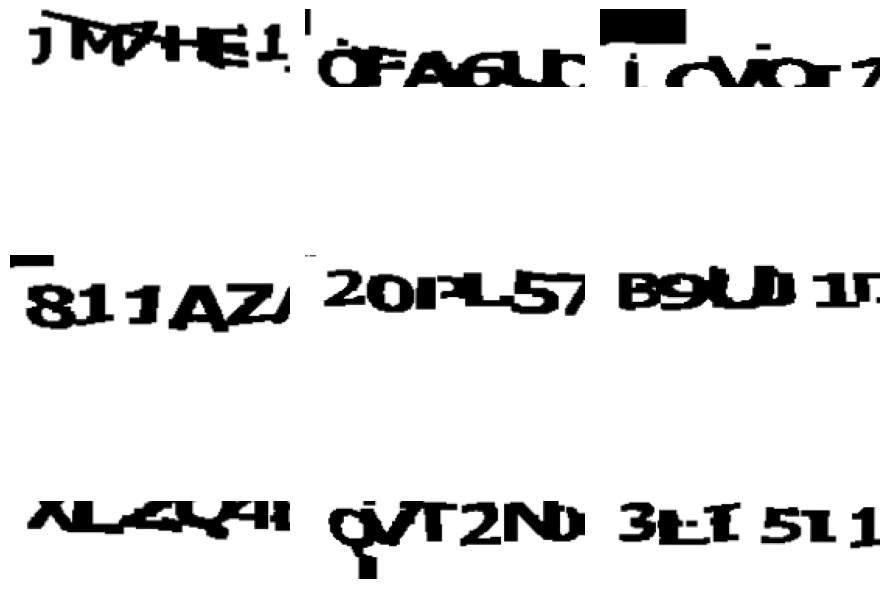

In [13]:
augmented_images, augmented_labels = next(augmented_data_generator)

# Display the first few augmented images and their corresponding labels
plt.figure(figsize=(9, 9))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[i].reshape(50, 180), cmap='gray')  # Assuming images are grayscale
    plt.axis('off')
plt.tight_layout()
plt.show()

In [14]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def psnr(y_true, y_pred):
    max_pixel = 1.0
    return tf.image.psnr(y_true, y_pred, max_val=max_pixel)

In [15]:
#Camada Convolution-BatchNorm-ReLu
def CK(filters, kernel_size=(3, 3), strides=(1, 1), padding='same', use_batch_norm=True, downsample=True,num_blocks=2):
    '''
        filters: quantidade de filtros
        kernel_size 3x3 | strides 1x1 | padding same | sao constantes durante o codigo
        use_batch_norm ->   indica quando devemos usar BatchNormalization, em caso de negativo, a camada se torna a Identidade
        downsample ->       indica se a dimensao deve aumentar ou diminuir 
    '''

    # Esse chavemento usando  if ternario serve para selecionar as camadas com base nos atributos
    conv = Conv2D               if downsample       else Conv2DTranspose
    norm = BatchNormalization   if use_batch_norm   else Identity
    actf = LeakyReLU(0.2)       if downsample       else ReLU()
    pool = MaxPooling2D((2, 2), padding='same') if downsample else UpSampling2D((2, 2))
    # alpha de 0.2 na LeakyReLU foi definido no paper original

    # Com o chaveamento pronto, a camada pode ser montada sequencialmente
    def layer(x):
        for _ in range(num_blocks):
            x = conv(filters, kernel_size, strides=strides, padding=padding)(x)
            x = norm()(x)
            x = actf(x)
        x = pool(x)
        return x
    return layer

In [16]:
def crop_and_concat(x1, x2):
    # Crop x2 to the shape of x1
    x1_shape = x1.shape
    x2_shape = x2.shape
    height_diff = x2_shape[1] - x1_shape[1]
    width_diff = x2_shape[2] - x1_shape[2]

    cropping = ((height_diff // 2, height_diff - height_diff // 2),
                (width_diff // 2, width_diff - width_diff // 2))
    x2_cropped = Cropping2D(cropping)(x2)
    return concatenate([x1, x2_cropped])

In [17]:
def generator(input_nc, output_nc, ngf, num_blocks=1, num_downsample=3):
    # Aqui, definimos o modelo gerador
    
    # Ele deve receber uma imagem (img_size,img_size,input_nc)
    inputs = Input(shape=(50, 180, input_nc))

    # --------------- START ENCODER --------------------------

    x = inputs

    # Uma convolucao eh aplicada inicialmente sem o batch_norm
    x = CK(ngf,use_batch_norm=False,num_blocks=num_blocks)(x)
    # img_shape = img_size/2,img_size/2,ngf

    # Aqui implementamos o caminho onde a dimensao da imagem vai diminuindo
    #Armazenamos as skip connections
    skips = []
    for i in range(num_downsample):
        # Como o numero de filtros vai aumentando exponencialmente, existe um momento em que o crescimento eh cessado e a qtd se torna constante
        # Este e o momento em que i+1 >= num_downsample
        # A partir dai, o numero de filtros nao diminui
        expo = min(i+1,num_downsample)
        # Aplicamos convolucao com o numero de filtros escolhido
        x = CK(ngf*(2**(expo)),num_blocks=num_blocks)(x)
        # Guardamos a coneccao
        skips.append(x)


    shape_before_flattening = x.shape[1:]
    x = Flatten()(x)
    x = Dense(32, activation='relu')(x)
    # --------------- FIM   ENCODER --------------------------
    '''
    Aqui, a imagem esta no formato:
    img_shape = img_size/(num_downsample + num_blocks),img_size/(num_downsample + num_blocks),ngf*(2**(expo))
    
    '''
    # --------------- START DECODER --------------------------

    # As conexoes sao processadas de tras pra frente, ja que a ultima skip gerada vai se ligar com a primeira camada do decoder
    skips = list(reversed(skips))

    x = Dense(np.prod(shape_before_flattening), activation='relu')(x)
    x = Reshape(shape_before_flattening)(x)
    # Para as skips que sobraram, devemos conecta-las a camadas sem dropout
    for skip in skips:
        # x = Concatenate()([x, skip])
        x = crop_and_concat(skip,x)
        x = CK(ngf * (2 ** i),downsample=False,num_blocks=num_blocks)(x)
    
    #    img_shape = img_size/(2),img_size/(2),ngf*(2**(expo))
    # --------------- FIM   DECODER --------------------------

    # Por fim, uma ultima convolucao com TanH para gerar o resultado final
    # Numero de canais = output_nc  = 3 = RGB
    x = Conv2DTranspose(ngf, (4, 4),strides=(2,2), activation='relu',padding="same")(x)
    x = Conv2D(ngf, (3, 1),strides=(1,1), activation='relu')(x)
    output = Conv2D(output_nc, (1, 1),strides=(1,1), activation='sigmoid')(x)
    return Model(inputs=inputs, outputs=output)

autoencoder = generator(1, 1, 32, num_blocks=3, num_downsample=4)
autoencoder.compile(optimizer=Adam(2e-4, beta_1=0.5,beta_2=0.999), loss="binary_crossentropy",metrics=[rmse,psnr])
autoencoder.summary()

2024-08-02 15:37:45.398274: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13874 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 50, 180, 1)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 50, 180, 32)          320       ['input_1[0][0]']             
                                                                                                  
 identity (Identity)         (None, 50, 180, 32)          0         ['conv2d[0][0]']              
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 50, 180, 32)          0         ['identity[0][0]',            
                                                                     'identity_1[0][0]',      

In [18]:
checkpoint = ModelCheckpoint(
    'model_BCE_aug_best_unet.tf',
    monitor='val_rmse',
    save_best_only=True,
    mode='min',
    verbose=1
)

In [19]:
history = autoencoder.fit(augmented_data_generator,
                steps_per_epoch=len(X_train) // batch_size,
                epochs=300,
                batch_size=batch_size,
                shuffle=True,
                callbacks=[checkpoint],
                validation_data=(X_val, Y_val))

Epoch 1/300


2024-08-02 15:37:51.677192: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2024-08-02 15:37:52.782715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-08-02 15:37:54.066199: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7116750 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-02 15:37:54.066236: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2024-08-02 15:37:54.070386: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-02 15:37:54.175380: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

123/123 [==============================] - ETA: 0s - loss: 0.1234 - rmse: 0.1718 - psnr: 15.4837
Epoch 1: val_rmse improved from inf to 0.22475, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 50s 256ms/step - loss: 0.1234 - rmse: 0.1718 - psnr: 15.4837 - val_loss: 0.2119 - val_rmse: 0.2247 - val_psnr: 12.9662
Epoch 2/300
123/123 [==============================] - ETA: 0s - loss: 0.0789 - rmse: 0.1341 - psnr: 17.4635
Epoch 2: val_rmse improved from 0.22475 to 0.17609, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 31s 255ms/step - loss: 0.0789 - rmse: 0.1341 - psnr: 17.4635 - val_loss: 0.1177 - val_rmse: 0.1761 - val_psnr: 15.0861
Epoch 3/300
123/123 [==============================] - ETA: 0s - loss: 0.0621 - rmse: 0.1096 - psnr: 19.2202
Epoch 3: val_rmse improved from 0.17609 to 0.15373, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 31s 250ms/step - loss: 0.0621 - rmse: 0.1096 - psnr: 19.2202 - val_loss: 0.1012 - val_rmse: 0.1537 - val_psnr: 16.2665
Epoch 4/300
123/123 [==============================] - ETA: 0s - loss: 0.0515 - rmse: 0.0918 - psnr: 20.7596
Epoch 4: val_rmse improved from 0.15373 to 0.12268, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 29s 235ms/step - loss: 0.0515 - rmse: 0.0918 - psnr: 20.7596 - val_loss: 0.0713 - val_rmse: 0.1227 - val_psnr: 18.2262
Epoch 5/300
123/123 [==============================] - ETA: 0s - loss: 0.0455 - rmse: 0.0803 - psnr: 21.9245
Epoch 5: val_rmse improved from 0.12268 to 0.07546, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 30s 243ms/step - loss: 0.0455 - rmse: 0.0803 - psnr: 21.9245 - val_loss: 0.0428 - val_rmse: 0.0755 - val_psnr: 22.4545
Epoch 6/300
123/123 [==============================] - ETA: 0s - loss: 0.0422 - rmse: 0.0734 - psnr: 22.7025
Epoch 6: val_rmse improved from 0.07546 to 0.07256, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 29s 236ms/step - loss: 0.0422 - rmse: 0.0734 - psnr: 22.7025 - val_loss: 0.0427 - val_rmse: 0.0726 - val_psnr: 22.7959
Epoch 7/300
123/123 [==============================] - ETA: 0s - loss: 0.0402 - rmse: 0.0693 - psnr: 23.2146
Epoch 7: val_rmse improved from 0.07256 to 0.06498, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 33s 267ms/step - loss: 0.0402 - rmse: 0.0693 - psnr: 23.2146 - val_loss: 0.0386 - val_rmse: 0.0650 - val_psnr: 23.7617
Epoch 8/300
123/123 [==============================] - ETA: 0s - loss: 0.0385 - rmse: 0.0652 - psnr: 23.7436
Epoch 8: val_rmse improved from 0.06498 to 0.05708, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 30s 246ms/step - loss: 0.0385 - rmse: 0.0652 - psnr: 23.7436 - val_loss: 0.0349 - val_rmse: 0.0571 - val_psnr: 24.8831
Epoch 9/300
123/123 [==============================] - ETA: 0s - loss: 0.0373 - rmse: 0.0629 - psnr: 24.0628
Epoch 9: val_rmse did not improve from 0.05708
123/123 [==============================] - 18s 146ms/step - loss: 0.0373 - rmse: 0.0629 - psnr: 24.0628 - val_loss: 0.0381 - val_rmse: 0.0635 - val_psnr: 23.9570
Epoch 10/300
123/123 [==============================] - ETA: 0s - loss: 0.0366 - rmse: 0.0611 - psnr: 24.3089
Epoch 10: val_rmse did not improve from 0.05708
123/123 [==============================] - 18s 147ms/step - loss: 0.0366 - rmse: 0.0611 - psnr: 24.3089 - val_loss: 0.0357 - val_rmse: 0.0588 - val_psnr: 24.6212
Epoch 11/300
123/123 [==============================] - ETA: 0s - loss: 0.0357 - rmse: 0.0586 - psnr: 24.6752
Epoch 11: val_rmse improved from 0.05708 to 0.04763, saving model to model_BCE_aug_best_un

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 34s 276ms/step - loss: 0.0357 - rmse: 0.0586 - psnr: 24.6752 - val_loss: 0.0320 - val_rmse: 0.0476 - val_psnr: 26.4923
Epoch 12/300
123/123 [==============================] - ETA: 0s - loss: 0.0354 - rmse: 0.0581 - psnr: 24.7638
Epoch 12: val_rmse did not improve from 0.04763
123/123 [==============================] - 18s 146ms/step - loss: 0.0354 - rmse: 0.0581 - psnr: 24.7638 - val_loss: 0.0386 - val_rmse: 0.0655 - val_psnr: 23.6998
Epoch 13/300
123/123 [==============================] - ETA: 0s - loss: 0.0348 - rmse: 0.0563 - psnr: 25.0416
Epoch 13: val_rmse improved from 0.04763 to 0.04677, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 34s 274ms/step - loss: 0.0348 - rmse: 0.0563 - psnr: 25.0416 - val_loss: 0.0315 - val_rmse: 0.0468 - val_psnr: 26.6487
Epoch 14/300
123/123 [==============================] - ETA: 0s - loss: 0.0345 - rmse: 0.0557 - psnr: 25.1289
Epoch 14: val_rmse improved from 0.04677 to 0.04332, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 27s 217ms/step - loss: 0.0345 - rmse: 0.0557 - psnr: 25.1289 - val_loss: 0.0305 - val_rmse: 0.0433 - val_psnr: 27.3079
Epoch 15/300
123/123 [==============================] - ETA: 0s - loss: 0.0340 - rmse: 0.0544 - psnr: 25.3401
Epoch 15: val_rmse improved from 0.04332 to 0.04146, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 28s 227ms/step - loss: 0.0340 - rmse: 0.0544 - psnr: 25.3401 - val_loss: 0.0299 - val_rmse: 0.0415 - val_psnr: 27.6985
Epoch 16/300
123/123 [==============================] - ETA: 0s - loss: 0.0338 - rmse: 0.0540 - psnr: 25.4054
Epoch 16: val_rmse did not improve from 0.04146
123/123 [==============================] - 18s 146ms/step - loss: 0.0338 - rmse: 0.0540 - psnr: 25.4054 - val_loss: 0.0306 - val_rmse: 0.0434 - val_psnr: 27.2996
Epoch 17/300
123/123 [==============================] - ETA: 0s - loss: 0.0336 - rmse: 0.0535 - psnr: 25.4865
Epoch 17: val_rmse did not improve from 0.04146
123/123 [==============================] - 18s 147ms/step - loss: 0.0336 - rmse: 0.0535 - psnr: 25.4865 - val_loss: 0.0300 - val_rmse: 0.0421 - val_psnr: 27.5358
Epoch 18/300
123/123 [==============================] - ETA: 0s - loss: 0.0334 - rmse: 0.0530 - psnr: 25.5752
Epoch 18: val_rmse did not improve from 0.04146
123/123 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 33s 267ms/step - loss: 0.0328 - rmse: 0.0515 - psnr: 25.8242 - val_loss: 0.0296 - val_rmse: 0.0408 - val_psnr: 27.8222
Epoch 23/300
123/123 [==============================] - ETA: 0s - loss: 0.0322 - rmse: 0.0497 - psnr: 26.1366
Epoch 23: val_rmse improved from 0.04082 to 0.03860, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 30s 248ms/step - loss: 0.0322 - rmse: 0.0497 - psnr: 26.1366 - val_loss: 0.0291 - val_rmse: 0.0386 - val_psnr: 28.2938
Epoch 24/300
123/123 [==============================] - ETA: 0s - loss: 0.0322 - rmse: 0.0494 - psnr: 26.1986
Epoch 24: val_rmse did not improve from 0.03860
123/123 [==============================] - 18s 147ms/step - loss: 0.0322 - rmse: 0.0494 - psnr: 26.1986 - val_loss: 0.0295 - val_rmse: 0.0400 - val_psnr: 27.9908
Epoch 25/300
123/123 [==============================] - ETA: 0s - loss: 0.0322 - rmse: 0.0498 - psnr: 26.1176
Epoch 25: val_rmse improved from 0.03860 to 0.03613, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 37s 301ms/step - loss: 0.0322 - rmse: 0.0498 - psnr: 26.1176 - val_loss: 0.0285 - val_rmse: 0.0361 - val_psnr: 28.8932
Epoch 26/300
123/123 [==============================] - ETA: 0s - loss: 0.0319 - rmse: 0.0490 - psnr: 26.2488
Epoch 26: val_rmse did not improve from 0.03613
123/123 [==============================] - 18s 147ms/step - loss: 0.0319 - rmse: 0.0490 - psnr: 26.2488 - val_loss: 0.0293 - val_rmse: 0.0391 - val_psnr: 28.2174
Epoch 27/300
123/123 [==============================] - ETA: 0s - loss: 0.0320 - rmse: 0.0491 - psnr: 26.2585
Epoch 27: val_rmse did not improve from 0.03613
123/123 [==============================] - 18s 147ms/step - loss: 0.0320 - rmse: 0.0491 - psnr: 26.2585 - val_loss: 0.0297 - val_rmse: 0.0403 - val_psnr: 27.9407
Epoch 28/300
123/123 [==============================] - ETA: 0s - loss: 0.0318 - rmse: 0.0488 - psnr: 26.2972
Epoch 28: val_rmse did not improve from 0.03613
123/123 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 28s 229ms/step - loss: 0.0318 - rmse: 0.0489 - psnr: 26.2635 - val_loss: 0.0283 - val_rmse: 0.0354 - val_psnr: 29.0637
Epoch 30/300
123/123 [==============================] - ETA: 0s - loss: 0.0316 - rmse: 0.0479 - psnr: 26.4637
Epoch 30: val_rmse did not improve from 0.03543
123/123 [==============================] - 18s 147ms/step - loss: 0.0316 - rmse: 0.0479 - psnr: 26.4637 - val_loss: 0.0296 - val_rmse: 0.0401 - val_psnr: 27.9578
Epoch 31/300
123/123 [==============================] - ETA: 0s - loss: 0.0316 - rmse: 0.0479 - psnr: 26.4592
Epoch 31: val_rmse did not improve from 0.03543
123/123 [==============================] - 18s 147ms/step - loss: 0.0316 - rmse: 0.0479 - psnr: 26.4592 - val_loss: 0.0292 - val_rmse: 0.0384 - val_psnr: 28.3614
Epoch 32/300
123/123 [==============================] - ETA: 0s - loss: 0.0315 - rmse: 0.0478 - psnr: 26.4701
Epoch 32: val_rmse did not improve from 0.03543
123/123 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 26s 210ms/step - loss: 0.0311 - rmse: 0.0468 - psnr: 26.6749 - val_loss: 0.0281 - val_rmse: 0.0345 - val_psnr: 29.2912
Epoch 37/300
123/123 [==============================] - ETA: 0s - loss: 0.0308 - rmse: 0.0458 - psnr: 26.8641
Epoch 37: val_rmse did not improve from 0.03449
123/123 [==============================] - 18s 145ms/step - loss: 0.0308 - rmse: 0.0458 - psnr: 26.8641 - val_loss: 0.0288 - val_rmse: 0.0376 - val_psnr: 28.5448
Epoch 38/300
123/123 [==============================] - ETA: 0s - loss: 0.0308 - rmse: 0.0458 - psnr: 26.8401
Epoch 38: val_rmse did not improve from 0.03449
123/123 [==============================] - 18s 146ms/step - loss: 0.0308 - rmse: 0.0458 - psnr: 26.8401 - val_loss: 0.0298 - val_rmse: 0.0410 - val_psnr: 27.7716
Epoch 39/300
123/123 [==============================] - ETA: 0s - loss: 0.0309 - rmse: 0.0462 - psnr: 26.7971
Epoch 39: val_rmse did not improve from 0.03449
123/123 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 26s 215ms/step - loss: 0.0301 - rmse: 0.0433 - psnr: 27.3621 - val_loss: 0.0280 - val_rmse: 0.0337 - val_psnr: 29.5306
Epoch 49/300
123/123 [==============================] - ETA: 0s - loss: 0.0303 - rmse: 0.0445 - psnr: 27.0933
Epoch 49: val_rmse did not improve from 0.03367
123/123 [==============================] - 18s 147ms/step - loss: 0.0303 - rmse: 0.0445 - psnr: 27.0933 - val_loss: 0.0280 - val_rmse: 0.0337 - val_psnr: 29.5147
Epoch 50/300
123/123 [==============================] - ETA: 0s - loss: 0.0298 - rmse: 0.0429 - psnr: 27.4533
Epoch 50: val_rmse improved from 0.03367 to 0.03345, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 26s 212ms/step - loss: 0.0298 - rmse: 0.0429 - psnr: 27.4533 - val_loss: 0.0278 - val_rmse: 0.0334 - val_psnr: 29.5704
Epoch 51/300
123/123 [==============================] - ETA: 0s - loss: 0.0298 - rmse: 0.0428 - psnr: 27.4332
Epoch 51: val_rmse improved from 0.03345 to 0.03312, saving model to model_BCE_aug_best_unet.tf
INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 27s 223ms/step - loss: 0.0298 - rmse: 0.0428 - psnr: 27.4332 - val_loss: 0.0278 - val_rmse: 0.0331 - val_psnr: 29.6635
Epoch 52/300
123/123 [==============================] - ETA: 0s - loss: 0.0300 - rmse: 0.0435 - psnr: 27.3120
Epoch 52: val_rmse did not improve from 0.03312
123/123 [==============================] - 18s 145ms/step - loss: 0.0300 - rmse: 0.0435 - psnr: 27.3120 - val_loss: 0.0281 - val_rmse: 0.0344 - val_psnr: 29.3341
Epoch 53/300
123/123 [==============================] - ETA: 0s - loss: 0.0298 - rmse: 0.0429 - psnr: 27.4270
Epoch 53: val_rmse did not improve from 0.03312
123/123 [==============================] - 18s 146ms/step - loss: 0.0298 - rmse: 0.0429 - psnr: 27.4270 - val_loss: 0.0283 - val_rmse: 0.0351 - val_psnr: 29.1350
Epoch 54/300
123/123 [==============================] - ETA: 0s - loss: 0.0297 - rmse: 0.0426 - psnr: 27.4808
Epoch 54: val_rmse improved from 0.03312 to 0.03279, saving model to model_BCE_aug_best_

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 26s 209ms/step - loss: 0.0297 - rmse: 0.0426 - psnr: 27.4808 - val_loss: 0.0278 - val_rmse: 0.0328 - val_psnr: 29.7869
Epoch 55/300
123/123 [==============================] - ETA: 0s - loss: 0.0294 - rmse: 0.0414 - psnr: 27.7565
Epoch 55: val_rmse did not improve from 0.03279
123/123 [==============================] - 18s 145ms/step - loss: 0.0294 - rmse: 0.0414 - psnr: 27.7565 - val_loss: 0.0288 - val_rmse: 0.0366 - val_psnr: 28.7996
Epoch 56/300
123/123 [==============================] - ETA: 0s - loss: 0.0296 - rmse: 0.0420 - psnr: 27.6031
Epoch 56: val_rmse did not improve from 0.03279
123/123 [==============================] - 18s 145ms/step - loss: 0.0296 - rmse: 0.0420 - psnr: 27.6031 - val_loss: 0.0283 - val_rmse: 0.0352 - val_psnr: 29.1162
Epoch 57/300
123/123 [==============================] - ETA: 0s - loss: 0.0294 - rmse: 0.0416 - psnr: 27.7021
Epoch 57: val_rmse did not improve from 0.03279
123/123 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 26s 213ms/step - loss: 0.0294 - rmse: 0.0414 - psnr: 27.7497 - val_loss: 0.0276 - val_rmse: 0.0319 - val_psnr: 30.0063
Epoch 63/300
123/123 [==============================] - ETA: 0s - loss: 0.0289 - rmse: 0.0396 - psnr: 28.1320
Epoch 63: val_rmse did not improve from 0.03192
123/123 [==============================] - 18s 148ms/step - loss: 0.0289 - rmse: 0.0396 - psnr: 28.1320 - val_loss: 0.0283 - val_rmse: 0.0347 - val_psnr: 29.2515
Epoch 64/300
123/123 [==============================] - ETA: 0s - loss: 0.0289 - rmse: 0.0397 - psnr: 28.1071
Epoch 64: val_rmse did not improve from 0.03192
123/123 [==============================] - 18s 145ms/step - loss: 0.0289 - rmse: 0.0397 - psnr: 28.1071 - val_loss: 0.0284 - val_rmse: 0.0354 - val_psnr: 29.1100
Epoch 65/300
123/123 [==============================] - ETA: 0s - loss: 0.0288 - rmse: 0.0395 - psnr: 28.1656
Epoch 65: val_rmse did not improve from 0.03192
123/123 [==============================]

INFO:tensorflow:Assets written to: model_BCE_aug_best_unet.tf/assets


123/123 [==============================] - 26s 212ms/step - loss: 0.0282 - rmse: 0.0370 - psnr: 28.7270 - val_loss: 0.0277 - val_rmse: 0.0319 - val_psnr: 30.0299
Epoch 82/300
  1/123 [..............................] - ETA: 23s - loss: 0.0267 - rmse: 0.0297 - psnr: 30.5420

KeyboardInterrupt: 

In [20]:
Y_train_pred = autoencoder.predict(X_train)
Y_val_pred = autoencoder.predict(X_val)

32/32 [==============================] - 1s 43ms/step


In [21]:
def display_images(images, Y, Y_pred, num_images=10):
    indices = np.random.choice(len(images), num_images, replace=False)
    plt.figure(figsize=(20, 6))
    for i, idx in enumerate(indices):
        # Original images
        ax = plt.subplot(3, num_images, i + 1)
        plt.imshow(images[idx].reshape(50,180), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Ground truth labels (Y)
        ax = plt.subplot(3, num_images, i + 1 + num_images)
        plt.imshow(Y[idx].reshape(50, 180), cmap="gray")
        plt.title("Y")
        plt.axis("off")

        # Reconstructed images (Y_pred)
        ax = plt.subplot(3, num_images, i + 1 + 2 * num_images)
        plt.imshow(Y_pred[idx].reshape(50, 180), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

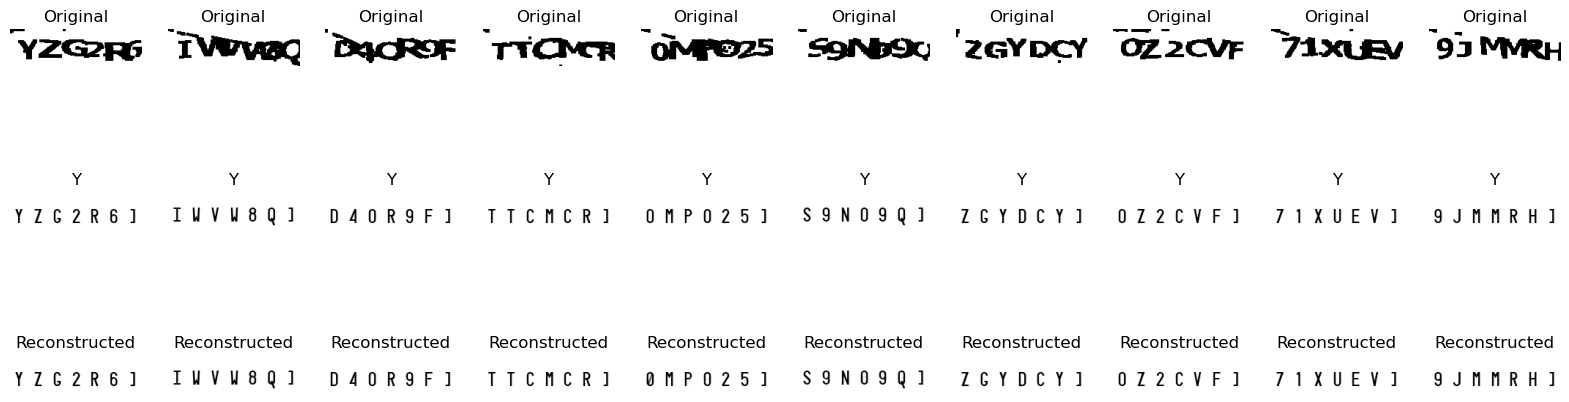

In [22]:
display_images(X_train, Y_train, Y_train_pred, num_images=10)

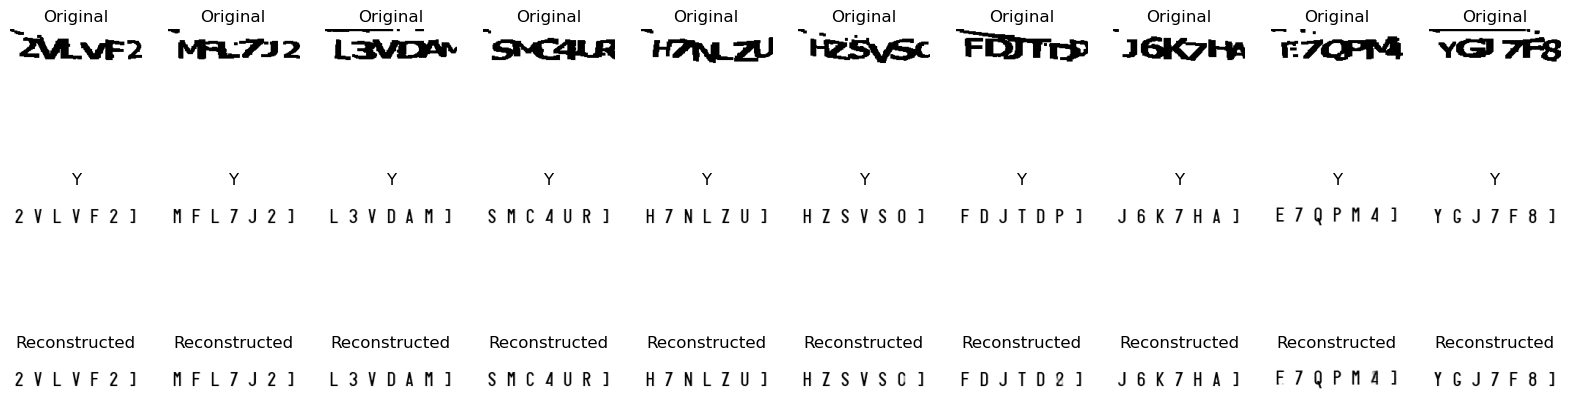

In [23]:
display_images(X_val, Y_val, Y_val_pred, num_images=10)